<a href="https://colab.research.google.com/github/bohuslavska/ai-house-fake-news-detection-homework/blob/master/Homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import numpy as np
import pandas as pd 
import string
import seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
pd.set_option('max_colwidth', 150)
from wordcloud import WordCloud, STOPWORDS
from statistics import mean

import nltk
nltk.download('stopwords')

import spacy
import re
from langdetect import detect as detect_lang
import calendar

from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import XGBClassifier

import ru_core_news_lg

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Short EDA

In [56]:
df_train = pd.read_csv('/content/drive/MyDrive/RNN_beginning/fake_detection_df_train.csv')
df_train

,id,text,label
0,00000_03514,"Чернигов прилет во многоэтажку. Говорят русская ракета, но сейчас хз, город ведь под контролем РФ. Люди прячьтесь в подвалы, таких случаев может б...",True
1,00002_06059,Председатель Следственного комитета РФ Александр Бастрыкин поручил проверить информацию об обстрелах украинскими силовиками станицы в Краснодарско...,True
2,00003_08645,Все сейчас массово хотят уехать со Львова.,True
3,00004_00901,"«К военным подошли бабушки и попросили убрать «Аллею славы героев Украины», сказали: «Мы ждали 8 лет вас, и дождались наконец». Ничто человеческое...",True
4,00006_06251,"С уважение отношусь к Лобаеву, но Владислав, если у вас есть вопросы к «прославленным» корреспондентам ВГТРК, обращайтесь. Тем более, уверен, знае...",True
...,...,...,...
875,08891_03363,"?? ?? ? Появились цели захватить Москву, Чечню и Крым?. Обращение Адама Осмаева, командира чеченского батальона им Джохара Дудаева касательно бата...",True
876,08892_01638,"В украинских пабликах пишут, что российский спецназ занял киевское метро. Подтвердить, так же как опровергнуть, пока сложно. Даже логически.",True
877,08893_03217,"Сообщается, что в дом попала ракета ПВО ВС Украины.",True
878,08896_08921,"В Росавиации сообщили , что с сегодняшнего дня Россия ограничивает использование своего неба для британских самолетов, включая транзит, в ответ на...",True


In [57]:
df_val = pd.read_csv('/content/drive/MyDrive/RNN_beginning/fake_detection_df_val.csv')
df_val

,id,text,label
0,00013_03711,"Украинские ИПсО продолжают снимать блокбастеры с """"""пленными"""""". Обратите внимание, раньше писали, что он из Ямпольского полка - теперь, что из Кы...",True
1,00024_04965,"«Финляндия готовится закрыть воздушное пространство для российского воздушного движения», — написал министр транспорта страны. Так она станет 10 е...",False
2,00030_08877,Корреспондент РИА Новости показывает последствия обстрела по детскому саду в Донецке,False
3,00050_05750,"Столтенберг верит, что война на Украине не распространится на НАТО, для этого альянс наращивает военное присутствие на востоке.",False
4,00057_04788,⚡️ Военнослужащие ЛНР без боя освободили два крупных города в Луганской области Армия Киева покинула Старобельск и Северодонецк. Эти данные подтве...,False
...,...,...,...
122,08848_08668,Принято решение отключать РФ от SWIFT - МИД Украины. Значит это ещё один шаг к признанию криптовалюты в России. Мир меняется.,True
123,08855_04438,"В ДНР заявили, что украинские силовики обстреляли село Лозовое минами калибра 120 мм. @rt_russian",True
124,08873_06191,"Франция намерена принять меры по борьбе с распространением российскими СМИ ""пропаганды"" в Европе. Соответствующее решение было принято по итогам з...",False
125,08878_04343,Макрон созывает на 19:00 мск Совет обороны страны по ситуации на Украине. @rt_russian,False


In [58]:
df_test = pd.read_csv('/content/drive/MyDrive/RNN_beginning/fake_detection_df_test.csv')
df_test

,id,text,label
0,00780_04282,"⚡️ Борис Джонсон предлагает лидерам стран НАТО принять немедленные меры в отношении России по SWIFT. Как заявили на Даунинг-стрит, Лондон в ближай...",False
1,00784_05901,"Зеленский сообщил о новых поставках оружия от Запада. ""Новый день на дипломатическом фронте начали с разговора с президентом Франции Эмманюэлем Ма...",False
2,00786_05398,"Бесстыдство — главная черта западных коллег, но в случае с Украиной оно вышло за все пределы, заявил Лавров.",True
3,00788_04827,⚡️ Зеленский вновь предложил Владимиру Путину начать переговоры ⚡️ Владимир Путин заявил о готовности к переговорам с Украиной Во время переговоро...,False
4,00797_04856,И вдогонку — оказавшийся под санкциями ВТБ избавляется от контроля над футбольным клубом «Динамо». Теперь «Динамо» само по себе: контрольный пакет...,False
...,...,...,...
243,00736_01910,"Авиабаза в Василькове под Киевом под полным контролем ССО и ВДВ России. Никаких попыток штурма ВСУ больше не предпринимает, просто ведется массиро...",True
244,00756_01063,"Тут фото украинской военной техники, стоящей на территории Одесского оперного театра, публикуют. Ещё одна причина быстрее закончить эту войну",True
245,00776_05933,"Центр им. Гамалеи подал документы для изменения протокола клинических исследований вакцины против коронавируса у детей от 6 до 11 лет, работа с де...",False
246,08803_00778,Подпишитесь на канал РБК:. https://www.youtube.com/user/tvrbcnews?sub_confirmation=1. ---------------------. Минобороны заявило о нападения 16 кат...,True


In [59]:
#Let's check if datasets contain any missing values.

combined = [df_train, df_val, df_test]
for d in combined:
  print(d.isnull().sum())

id       0
text     0
label    0
dtype: int64
id       0
text     0
label    0
dtype: int64
id       0
text     0
label    0
dtype: int64


In [60]:
#Let's check distribution of news propaganda across the datasets.

for d in combined:
  print(d["label"].value_counts())

True     544
False    336
Name: label, dtype: int64
True     79
False    48
Name: label, dtype: int64
True     139
False    109
Name: label, dtype: int64


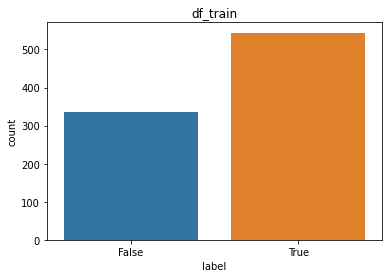

In [61]:
sns.countplot(x = df_train['label'], label='label').set(title='df_train');

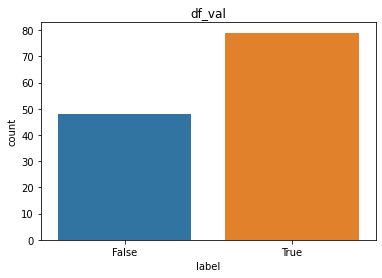

In [62]:
sns.countplot(x = df_val['label'], label='label').set(title='df_val');

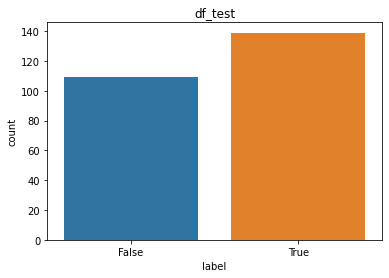

In [63]:
sns.countplot(x = df_test['label'], label='label').set(title='df_test');

> ### Datasets seem to be not very balanced. That is why we will later use StratifiedKFold for training data cross-validation.

In [64]:
#Let's find out languages of the news propaganda across the datasets.

def detect_lang_with_excep(input):
    try:
        return detect_lang(input)
    except:
        return "none"
for d in combined:
  d["lang"] = d["text"].apply(detect_lang_with_excep)
  print(d["lang"].value_counts())

ru    868
bg      6
uk      2
mk      2
da      1
so      1
Name: lang, dtype: int64
ru    123
bg      2
ro      1
en      1
Name: lang, dtype: int64
ru      241
uk        3
bg        2
mk        1
none      1
Name: lang, dtype: int64


# Text Preprocessing and Modifications of the Datasets

In [65]:
#Function for the text preprocessing.
#As a part of TODO task I used here ru_core_news_sm - pipeline for russian in spaCy.

nlp = spacy.load('ru_core_news_lg')

def remove_emojis(data):
    emoj = re.compile("["
        u"\U00002700-\U000027BF"  # Dingbats
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U00002600-\U000026FF"  # Miscellaneous Symbols
        u"\U0001F300-\U0001F5FF"  # Miscellaneous Symbols And Pictographs
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U0001F680-\U0001F6FF"  # Transport and Map Symbols
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def text_preprocessing(text):
    text = remove_emojis(text)
    russian_stop_words = stopwords.words('russian')
    lower_text = [i.lower() for i in text]
    no_latin = [i for i in lower_text if i not in list(string.ascii_letters)]
    no_punct = [i for i in no_latin if i not in list(string.punctuation)]
    no_punct = ''.join(no_punct)
    no_sw = [i for i in no_punct.split() if i not in russian_stop_words]
    no_sw = ' '.join(no_sw)
    document = nlp(no_sw)
    result = " ".join([token.lemma_ for token in document])
    return result

In [66]:
for d in combined:
  d['preprocessed_text'] = d['text'].apply(lambda x: text_preprocessing(x))

In [67]:
df_train.head(5)

,id,text,label,lang,preprocessed_text
0,00000_03514,"Чернигов прилет во многоэтажку. Говорят русская ракета, но сейчас хз, город ведь под контролем РФ. Люди прячьтесь в подвалы, таких случаев может б...",True,ru,чернигов прилёт многоэтажка говорить русский ракета хз город контроль рф человек прятаться подвал такой случай
1,00002_06059,Председатель Следственного комитета РФ Александр Бастрыкин поручил проверить информацию об обстрелах украинскими силовиками станицы в Краснодарско...,True,ru,председатель следственный комитет рф александр бастрыкин поручить проверить информация обстрел украинскими силовик станица краснодарский край данн...
2,00003_08645,Все сейчас массово хотят уехать со Львова.,True,ru,массово хотеть уехать львов
3,00004_00901,"«К военным подошли бабушки и попросили убрать «Аллею славы героев Украины», сказали: «Мы ждали 8 лет вас, и дождались наконец». Ничто человеческое...",True,ru,""" к военный подойти бабушка попросить убрать "" аллея слава герой украина "" сказать "" мы ждать 8 год дождаться наконец "" ничто человеческий чуждо в..."
4,00006_06251,"С уважение отношусь к Лобаеву, но Владислав, если у вас есть вопросы к «прославленным» корреспондентам ВГТРК, обращайтесь. Тем более, уверен, знае...",True,ru,"уважение относиться лобаеву владислав вопрос "" прославленным "" корреспондент вгтрк обращаться уверенный знать выйти связь растолкую публичный исте..."


In [68]:
df_val.head(5)

,id,text,label,lang,preprocessed_text
0,00013_03711,"Украинские ИПсО продолжают снимать блокбастеры с """"""пленными"""""". Обратите внимание, раньше писали, что он из Ямпольского полка - теперь, что из Кы...",True,ru,украинские ипсо продолжать снимать блокбастер пленный обратить внимание раньше писать ямпольского полок кызылюрта
1,00024_04965,"«Финляндия готовится закрыть воздушное пространство для российского воздушного движения», — написал министр транспорта страны. Так она станет 10 е...",False,ru,""" финляндия готовиться закрыть воздушный пространство российский воздушный движение "" — написать министр транспорт страна стать 10 европейский стр..."
2,00030_08877,Корреспондент РИА Новости показывает последствия обстрела по детскому саду в Донецке,False,ru,корреспондент риа новость показывать последствие обстрел детский сад донецке
3,00050_05750,"Столтенберг верит, что война на Украине не распространится на НАТО, для этого альянс наращивает военное присутствие на востоке.",False,ru,столтенберг верить война украина распространиться нато альянс наращивать военный присутствие востоке
4,00057_04788,⚡️ Военнослужащие ЛНР без боя освободили два крупных города в Луганской области Армия Киева покинула Старобельск и Северодонецк. Эти данные подтве...,False,ru,️ военнослужащий лнр бой освободить крупный город луганский область армия киев покинуть старобельск северодонецк данные подтверждать местный жител...


In [69]:
df_test.head(5)

,id,text,label,lang,preprocessed_text
0,00780_04282,"⚡️ Борис Джонсон предлагает лидерам стран НАТО принять немедленные меры в отношении России по SWIFT. Как заявили на Даунинг-стрит, Лондон в ближай...",False,ru,"️ борис джонсон предлагать лидер страна нато принять немедленный мера отношение россия заявить даунингстрит лондон близкий время ввести санкция "" ..."
1,00784_05901,"Зеленский сообщил о новых поставках оружия от Запада. ""Новый день на дипломатическом фронте начали с разговора с президентом Франции Эмманюэлем Ма...",False,ru,зеленский сообщить новый поставка оружие запад новый день дипломатический фронт начать разговор президент франция эмманюэлем макрон нам следовать ...
2,00786_05398,"Бесстыдство — главная черта западных коллег, но в случае с Украиной оно вышло за все пределы, заявил Лавров.",True,ru,бесстыдство — главный черта западный коллега случай украина оно выйти предел заявить лавров
3,00788_04827,⚡️ Зеленский вновь предложил Владимиру Путину начать переговоры ⚡️ Владимир Путин заявил о готовности к переговорам с Украиной Во время переговоро...,False,ru,️ зеленский вновь предложить владимир путин начать переговоры ️ владимир путин заявить готовность переговорам украина время переговоров лидер кнр ...
4,00797_04856,И вдогонку — оказавшийся под санкциями ВТБ избавляется от контроля над футбольным клубом «Динамо». Теперь «Динамо» само по себе: контрольный пакет...,False,ru,"вдогонку — оказаться санкция втб избавляться контроль футбольный клуб "" динамо "" "" динамо "" само контрольный пакет акция футбольный "" динамо "" пер..."


### Let's delete the uninformative id column, the column with unprocessed text, all duplicates, and the news that are not in russian.

In [70]:
for d in combined:
  print(d.shape)
  d.drop_duplicates(inplace=True)
  d.drop(d[d.lang != 'ru'].index, inplace=True)
  d.drop(columns = ['id', 'text', 'lang'], inplace = True)
  d['label'] = d['label'] * 1
  d.reset_index(drop = True, inplace = True)
  print(d.shape)

(880, 5)
(868, 2)
(127, 5)
(123, 2)
(248, 5)
(241, 2)


In [71]:
df_train.head(5)

,label,preprocessed_text
0,1,чернигов прилёт многоэтажка говорить русский ракета хз город контроль рф человек прятаться подвал такой случай
1,1,председатель следственный комитет рф александр бастрыкин поручить проверить информация обстрел украинскими силовик станица краснодарский край данн...
2,1,массово хотеть уехать львов
3,1,""" к военный подойти бабушка попросить убрать "" аллея слава герой украина "" сказать "" мы ждать 8 год дождаться наконец "" ничто человеческий чуждо в..."
4,1,"уважение относиться лобаеву владислав вопрос "" прославленным "" корреспондент вгтрк обращаться уверенный знать выйти связь растолкую публичный исте..."


In [72]:
df_val.head(5)

,label,preprocessed_text
0,1,украинские ипсо продолжать снимать блокбастер пленный обратить внимание раньше писать ямпольского полок кызылюрта
1,0,""" финляндия готовиться закрыть воздушный пространство российский воздушный движение "" — написать министр транспорт страна стать 10 европейский стр..."
2,0,корреспондент риа новость показывать последствие обстрел детский сад донецке
3,0,столтенберг верить война украина распространиться нато альянс наращивать военный присутствие востоке
4,0,️ военнослужащий лнр бой освободить крупный город луганский область армия киев покинуть старобельск северодонецк данные подтверждать местный жител...


In [73]:
df_test.head(5)

,label,preprocessed_text
0,0,"️ борис джонсон предлагать лидер страна нато принять немедленный мера отношение россия заявить даунингстрит лондон близкий время ввести санкция "" ..."
1,0,зеленский сообщить новый поставка оружие запад новый день дипломатический фронт начать разговор президент франция эмманюэлем макрон нам следовать ...
2,1,бесстыдство — главный черта западный коллега случай украина оно выйти предел заявить лавров
3,0,️ зеленский вновь предложить владимир путин начать переговоры ️ владимир путин заявить готовность переговорам украина время переговоров лидер кнр ...
4,0,"вдогонку — оказаться санкция втб избавляться контроль футбольный клуб "" динамо "" "" динамо "" само контрольный пакет акция футбольный "" динамо "" пер..."


# Wordcloud

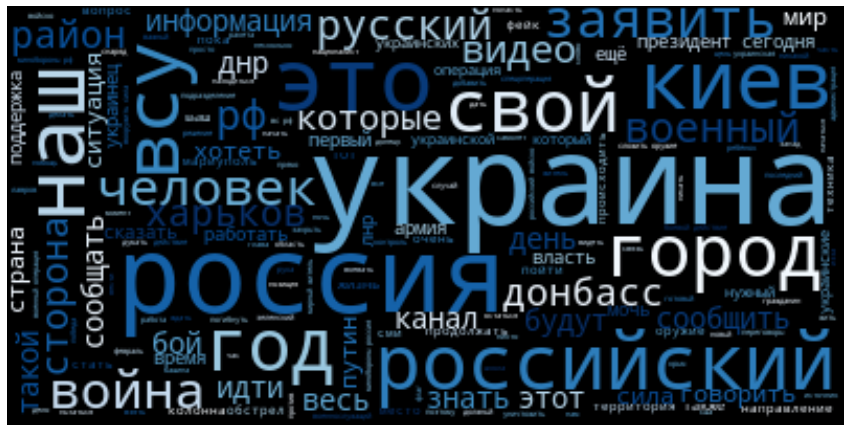

In [74]:
#Let's build a wordcloud.

sample=df_train[df_train.label==1]
text=sample.preprocessed_text.values

wc = WordCloud(max_font_size=60, background_color="black",max_words=700)
cloudtext = " ".join(text)

wc.generate(cloudtext)
plt.figure(figsize=(15,10))
plt.axis("off")
plt.imshow(wc.recolor(colormap= 'Blues' , random_state=17), interpolation="bilinear")
plt.show()

# Vectorization algoritmes (CountVectorizer, TfidfVectorizer, and spaCy embeddings).

### CountVectorizer

In [75]:
bagwords_obj = CountVectorizer()
bagwords_matrix = bagwords_obj.fit_transform(df_train["preprocessed_text"].iloc[:5])
print(f"Bag of Words: {bagwords_obj.get_feature_names_out()}")
print(f"News: {df_train['preprocessed_text'].iloc[0]}")
print(f"Vector: {bagwords_obj.transform([df_train['preprocessed_text'].iloc[0]]).toarray()[0]}")

Bag of Words: ['1658' 'александр' 'аллея' 'бабушка' 'бастрыкин' 'вгтрк' 'винтовка'
 'владислав' 'военный' 'вопрос' 'ворот' 'выйти' 'герб' 'герой' 'говорить'
 'год' 'город' 'гривен' 'данным' 'движение' 'делать' 'дипломат'
 'диппредставительства' 'дождаться' 'друг' 'друга' 'ждать' 'знать' 'идти'
 'информация' 'инцидент' 'ирландия' 'истерика' 'комитет' 'контроль'
 'корреспондент' 'край' 'краснодарский' 'лобаеву' 'луганск' 'луганский'
 'львов' 'магазин' 'массово' 'машина' 'многоэтажка' 'мы' 'наконец' 'ничто'
 'область' 'обращаться' 'обстрел' 'однако' 'одного' 'оживлённый'
 'освобождение' 'относиться' 'первый' 'перейти' 'переходе' 'повредить'
 'подвал' 'подойти' 'поздравлять' 'попросить' 'поручить' 'посольство'
 'пострадать' 'председатель' 'представитель' 'прекратить' 'прилёт'
 'проверить' 'происходить' 'прославленным' 'протестовать' 'против' 'прямо'
 'прятаться' 'публичный' 'ракета' 'растолкую' 'россия' 'ростовский'
 'рубль' 'русский' 'рф' 'связь' 'силовик' 'сказать' 'слава' 'следственный'

### TfidfVectorizer

In [76]:
tf_idf_obj = TfidfVectorizer()
tf_idf_matrix = tf_idf_obj.fit_transform(
    df_train["preprocessed_text"].iloc[:5]
)
print(f"Bag of Words: {tf_idf_obj.get_feature_names_out()}")
print(f"News : {df_train['preprocessed_text'].iloc[0]}")
print(f"Vectorization: {tf_idf_obj.transform([df_train['preprocessed_text'].iloc[0]]).toarray()[0]}")

Bag of Words: ['1658' 'александр' 'аллея' 'бабушка' 'бастрыкин' 'вгтрк' 'винтовка'
 'владислав' 'военный' 'вопрос' 'ворот' 'выйти' 'герб' 'герой' 'говорить'
 'год' 'город' 'гривен' 'данным' 'движение' 'делать' 'дипломат'
 'диппредставительства' 'дождаться' 'друг' 'друга' 'ждать' 'знать' 'идти'
 'информация' 'инцидент' 'ирландия' 'истерика' 'комитет' 'контроль'
 'корреспондент' 'край' 'краснодарский' 'лобаеву' 'луганск' 'луганский'
 'львов' 'магазин' 'массово' 'машина' 'многоэтажка' 'мы' 'наконец' 'ничто'
 'область' 'обращаться' 'обстрел' 'однако' 'одного' 'оживлённый'
 'освобождение' 'относиться' 'первый' 'перейти' 'переходе' 'повредить'
 'подвал' 'подойти' 'поздравлять' 'попросить' 'поручить' 'посольство'
 'пострадать' 'председатель' 'представитель' 'прекратить' 'прилёт'
 'проверить' 'происходить' 'прославленным' 'протестовать' 'против' 'прямо'
 'прятаться' 'публичный' 'ракета' 'растолкую' 'россия' 'ростовский'
 'рубль' 'русский' 'рф' 'связь' 'силовик' 'сказать' 'слава' 'следственный'

### spaCy embeddings

In [77]:
spacy_doc = nlp(df_train['preprocessed_text'].iloc[0])
print(f"Word : {spacy_doc[4:6]}")
print(f"Vectorization: {spacy_doc[4:6].vector}")

Word : русский ракета
Vectorization: [ 0.01425679 -0.5669886   0.12041505 -0.23587576  0.17288575 -0.13392371
  0.2995437  -0.4346247   0.16733374  0.18758391  0.33906746  0.4971218
  0.4051843  -0.15918382 -0.38750103  0.02231722  0.12249431 -0.21369594
 -0.4812507   0.0989981  -0.06671913 -0.20488845 -0.08856308  0.0709147
  0.56542534  0.40344125 -0.1601729  -0.08104105 -0.24891722 -0.16286361
 -0.34603962 -0.3162595   0.6092106   0.18848944 -0.07879378 -0.06645019
  0.33946514  0.00402272  0.00641124  0.02457833 -0.21303582 -0.15144275
  0.08810832  0.44175255 -0.41162086 -0.65532494 -0.23724943  0.19871232
 -0.24809968 -0.19148612 -0.2135887  -0.09275804 -0.56041664  0.05942313
  0.25171313 -0.21448535  0.16768654  0.16070049  0.23400536  0.09383771
 -0.08553233 -0.3180006  -0.17217982  0.11907421 -0.05994843  0.2685193
  0.20289886 -0.13562253  0.19381541  0.16414058 -0.4234639   0.0886727
  0.05900873  0.30567926 -0.47433594 -0.01018484  0.2998517  -0.08173192
  0.04979998 -0.00

### Sentence Embeddings

In [78]:
sent_tr = SentenceTransformer('all-MiniLM-L6-v2')
print(
    f"Text : {df_train['preprocessed_text'].iloc[0]}\n"
    f"Vectorization: {sent_tr.encode([df_train['preprocessed_text'].iloc[0]])[0]}"
)

Text : чернигов прилёт многоэтажка говорить русский ракета хз город контроль рф человек прятаться подвал такой случай
Vectorization: [ 4.74238954e-02  5.75686209e-02  1.00506116e-02 -1.31483609e-02
 -5.98566979e-02  1.04855867e-02  7.00175166e-02  5.55670783e-02
 -6.95123300e-02 -3.33551131e-02 -2.06135195e-02  4.75089066e-03
  5.76341199e-03  6.01680651e-02 -3.38713266e-02 -7.44927526e-02
 -4.36194390e-02  5.25951423e-02 -1.76817309e-02 -2.71708500e-02
  1.25562279e-02 -2.09131110e-02  1.03015266e-01 -4.53248508e-02
 -4.03675027e-02  4.68088128e-02  3.73612046e-02 -3.72491702e-02
  2.85902768e-02  5.04774861e-02 -1.99244693e-02 -1.79526899e-02
 -3.96752991e-02 -5.40353581e-02 -2.73756981e-02  2.55898312e-02
 -2.52060276e-02  1.55123668e-02  1.05249360e-01  1.17986403e-01
 -7.77920634e-02 -1.10007793e-01 -8.69775862e-02  4.84830029e-02
 -1.58344745e-03  1.97514165e-02 -7.77240917e-02 -1.26986094e-02
  4.65275347e-02 -4.69705127e-02 -6.09597676e-02 -9.91788507e-03
 -3.26073654e-02  2.54

In [79]:
#As a part of TODO task I also used all-distilroberta-v1 model.

sent_tr = SentenceTransformer('all-distilroberta-v1')
print(
    f"Text : {df_train['preprocessed_text'].iloc[0]}\n"
    f"Vectorization: {sent_tr.encode([df_train['preprocessed_text'].iloc[0]])[0]}"
)

Text : чернигов прилёт многоэтажка говорить русский ракета хз город контроль рф человек прятаться подвал такой случай
Vectorization: [-1.79527309e-02 -4.69298400e-02  2.71466896e-02  3.34173068e-02
 -1.01075344e-01 -8.51130262e-02 -3.62485200e-02 -4.29621758e-03
 -2.32357159e-02 -1.97555609e-02  1.85212661e-02 -4.64079976e-02
  3.02703790e-02 -9.16027799e-02  2.00984385e-02 -5.74494600e-02
 -2.10079029e-02 -3.57038379e-02  2.23191082e-02  6.94614574e-02
  2.87128463e-02  3.07675060e-02 -2.81201978e-03 -2.60788612e-02
 -7.99435750e-02 -9.27732605e-03  2.46676691e-02 -2.47033071e-02
 -1.04830861e-01 -1.85375996e-02 -3.56475860e-02  1.74174253e-02
  1.31863849e-02  7.40202330e-03 -3.70682850e-02 -5.96097903e-03
  1.66305229e-02 -3.62976193e-02  4.25684787e-02  3.07039041e-02
  3.22657526e-02  5.30585870e-02  2.67542619e-02 -1.41777331e-02
 -1.48974843e-02  3.48412246e-02 -4.90350723e-02  2.01115124e-02
  3.33132073e-02 -1.50452880e-02  1.95686258e-02 -2.87820138e-02
 -1.68645047e-02  1.49

# StratifiedKFold

In [80]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [81]:
#Function for all the models we are going to use later.

def stratified_KF(model):
    list_test = []
    for fold_id, (train_index, test_index) in enumerate(skf.split(df_train['preprocessed_text'], df_train['label'])):
        X_train_fold, X_test_fold = df_train['preprocessed_text'][train_index], df_train['preprocessed_text'][test_index]
        y_train_fold, y_test_fold = df_train['label'][train_index], df_train['label'][test_index]
        
        model.fit(X_train_fold, y_train_fold)
        
        train_preds = model.predict_proba(X_train_fold)[:,1] #probabilities that a particular data point falls into the underlying classes
        test_preds = model.predict_proba(X_test_fold)[:,1]
        
        train_targets = y_train_fold.values 
        test_targets = y_test_fold.values  
        
        roc_auc_test = roc_auc_score(test_targets, test_preds)
        roc_auc_train = roc_auc_score(train_targets, train_preds)
        list_test.append(roc_auc_test)        
        
        print(f'Fold {fold_id}')
        print('Train Roc Auc Score:', roc_auc_train)
        print('Test Roc Auc Score:', roc_auc_test)

    print('\nList of Possible Test Roc Auc Scores:', list_test)
    print('Maximum Test Roc Auc Score:', max(list_test))
    print('Minimum Test Roc Auc Score:', min(list_test))
    print('Overall Test Roc Auc Score:', mean(list_test))

# Vectorizers + Models

### CountVectorizer + LogisticRegression

In [82]:
model = Pipeline([("vectorizer", CountVectorizer()),
        ("log_reg", LogisticRegression())])
stratified_KF(model)

Fold 0
Train Roc Auc Score: 0.9999911648289511
Test Roc Auc Score: 0.733803810868031
Fold 1
Train Roc Auc Score: 0.9999646058418058
Test Roc Auc Score: 0.6742424242424243
Fold 2
Train Roc Auc Score: 0.9999380602231602
Test Roc Auc Score: 0.7032828282828283
Fold 3
Train Roc Auc Score: 0.9999647409340127
Test Roc Auc Score: 0.6705128205128205
Fold 4
Train Roc Auc Score: 0.9998501489695538
Test Roc Auc Score: 0.7267806267806267

List of Possible Test Roc Auc Scores: [0.733803810868031, 0.6742424242424243, 0.7032828282828283, 0.6705128205128205, 0.7267806267806267]
Maximum Test Roc Auc Score: 0.733803810868031
Minimum Test Roc Auc Score: 0.6705128205128205
Overall Test Roc Auc Score: 0.7017245021373462


### TfidfVectorizer + LogisticRegression

In [83]:
model = Pipeline([("vectorizer", TfidfVectorizer()),
        ("log_reg", LogisticRegression())])
stratified_KF(model)

Fold 0
Train Roc Auc Score: 0.9954675572519084
Test Roc Auc Score: 0.7144671841919548
Fold 1
Train Roc Auc Score: 0.9963544017059984
Test Roc Auc Score: 0.691358024691358
Fold 2
Train Roc Auc Score: 0.9943634803075752
Test Roc Auc Score: 0.6815375982042648
Fold 3
Train Roc Auc Score: 0.9953546180561678
Test Roc Auc Score: 0.7041310541310541
Fold 4
Train Roc Auc Score: 0.9930275197010031
Test Roc Auc Score: 0.7267806267806268

List of Possible Test Roc Auc Scores: [0.7144671841919548, 0.691358024691358, 0.6815375982042648, 0.7041310541310541, 0.7267806267806268]
Maximum Test Roc Auc Score: 0.7267806267806268
Minimum Test Roc Auc Score: 0.6815375982042648
Overall Test Roc Auc Score: 0.7036548975998517


### CountVectorizer + Multinomial Naive Bayes classifier

In [84]:
model = Pipeline([("vectorizer", CountVectorizer()),
        ("nb", MultinomialNB())])
stratified_KF(model)

Fold 0
Train Roc Auc Score: 0.9844545165394403
Test Roc Auc Score: 0.7489061397318277
Fold 1
Train Roc Auc Score: 0.9843911762363622
Test Roc Auc Score: 0.7240460157126823
Fold 2
Train Roc Auc Score: 0.9802854538858362
Test Roc Auc Score: 0.7443883277216612
Fold 3
Train Roc Auc Score: 0.9849620083563986
Test Roc Auc Score: 0.7016381766381766
Fold 4
Train Roc Auc Score: 0.9822735045748637
Test Roc Auc Score: 0.7484330484330484

List of Possible Test Roc Auc Scores: [0.7489061397318277, 0.7240460157126823, 0.7443883277216612, 0.7016381766381766, 0.7484330484330484]
Maximum Test Roc Auc Score: 0.7489061397318277
Minimum Test Roc Auc Score: 0.7016381766381766
Overall Test Roc Auc Score: 0.7334823416474793


### TfidfVectorizer + Multinomial Naive Bayes classifier

In [85]:
model = Pipeline([("vectorizer", TfidfVectorizer()),
        ("nb", MultinomialNB())])
stratified_KF(model)

Fold 0
Train Roc Auc Score: 0.9938772264631043
Test Roc Auc Score: 0.7398729710656315
Fold 1
Train Roc Auc Score: 0.9941599638979586
Test Roc Auc Score: 0.7067901234567902
Fold 2
Train Roc Auc Score: 0.9907267305531222
Test Roc Auc Score: 0.7260101010101009
Fold 3
Train Roc Auc Score: 0.9912998254676233
Test Roc Auc Score: 0.6937321937321936
Fold 4
Train Roc Auc Score: 0.9885496183206106
Test Roc Auc Score: 0.73005698005698

List of Possible Test Roc Auc Scores: [0.7398729710656315, 0.7067901234567902, 0.7260101010101009, 0.6937321937321936, 0.73005698005698]
Maximum Test Roc Auc Score: 0.7398729710656315
Minimum Test Roc Auc Score: 0.6937321937321936
Overall Test Roc Auc Score: 0.7192924738643393


### CountVectorizer + Random Forest Classifier

In [86]:
model = Pipeline([("vectorizer", CountVectorizer()),
        ("rf", RandomForestClassifier())])
stratified_KF(model)

Fold 0
Train Roc Auc Score: 1.0
Test Roc Auc Score: 0.7016231474947071
Fold 1
Train Roc Auc Score: 1.0
Test Roc Auc Score: 0.6740319865319866
Fold 2
Train Roc Auc Score: 1.0
Test Roc Auc Score: 0.6189674523007858
Fold 3
Train Roc Auc Score: 1.0
Test Roc Auc Score: 0.6496438746438746
Fold 4
Train Roc Auc Score: 1.0
Test Roc Auc Score: 0.7398860398860398

List of Possible Test Roc Auc Scores: [0.7016231474947071, 0.6740319865319866, 0.6189674523007858, 0.6496438746438746, 0.7398860398860398]
Maximum Test Roc Auc Score: 0.7398860398860398
Minimum Test Roc Auc Score: 0.6189674523007858
Overall Test Roc Auc Score: 0.6768305001714788


### TfidfVectorizer + Random Forest Classifier

In [87]:
model = Pipeline([("vectorizer", TfidfVectorizer()),
        ("rf", RandomForestClassifier())])
stratified_KF(model)

Fold 0
Train Roc Auc Score: 1.0
Test Roc Auc Score: 0.6659139026111502
Fold 1
Train Roc Auc Score: 1.0
Test Roc Auc Score: 0.6658249158249159
Fold 2
Train Roc Auc Score: 0.9999999999999999
Test Roc Auc Score: 0.5384399551066217
Fold 3
Train Roc Auc Score: 1.0
Test Roc Auc Score: 0.6693732193732194
Fold 4
Train Roc Auc Score: 1.0
Test Roc Auc Score: 0.7144586894586895

List of Possible Test Roc Auc Scores: [0.6659139026111502, 0.6658249158249159, 0.5384399551066217, 0.6693732193732194, 0.7144586894586895]
Maximum Test Roc Auc Score: 0.7144586894586895
Minimum Test Roc Auc Score: 0.5384399551066217
Overall Test Roc Auc Score: 0.6508021364749194


### CountVectorizer + XgBoost Classifier

In [88]:
model = Pipeline([("vectorizer", TfidfVectorizer()),
        ("xgb", xgb.XGBClassifier())])

stratified_KF(model)

Fold 0
Train Roc Auc Score: 0.923376979078315
Test Roc Auc Score: 0.689484827099506
Fold 1
Train Roc Auc Score: 0.9265659702866043
Test Roc Auc Score: 0.647516835016835
Fold 2
Train Roc Auc Score: 0.9306672683673559
Test Roc Auc Score: 0.652847923681257
Fold 3
Train Roc Auc Score: 0.9200941417061863
Test Roc Auc Score: 0.6614672364672364
Fold 4
Train Roc Auc Score: 0.9312448213246832
Test Roc Auc Score: 0.6904558404558404

List of Possible Test Roc Auc Scores: [0.689484827099506, 0.647516835016835, 0.652847923681257, 0.6614672364672364, 0.6904558404558404]
Maximum Test Roc Auc Score: 0.6904558404558404
Minimum Test Roc Auc Score: 0.647516835016835
Overall Test Roc Auc Score: 0.6683545325441349


### TfidfVectorizer + XgBoost Classifier

In [89]:
model = Pipeline([("vectorizer", TfidfVectorizer()),
        ("xgb", xgb.XGBClassifier())])
stratified_KF(model)

Fold 0
Train Roc Auc Score: 0.923376979078315
Test Roc Auc Score: 0.689484827099506
Fold 1
Train Roc Auc Score: 0.9265659702866043
Test Roc Auc Score: 0.647516835016835
Fold 2
Train Roc Auc Score: 0.9306672683673559
Test Roc Auc Score: 0.652847923681257
Fold 3
Train Roc Auc Score: 0.9200941417061863
Test Roc Auc Score: 0.6614672364672364
Fold 4
Train Roc Auc Score: 0.9312448213246832
Test Roc Auc Score: 0.6904558404558404

List of Possible Test Roc Auc Scores: [0.689484827099506, 0.647516835016835, 0.652847923681257, 0.6614672364672364, 0.6904558404558404]
Maximum Test Roc Auc Score: 0.6904558404558404
Minimum Test Roc Auc Score: 0.647516835016835
Overall Test Roc Auc Score: 0.6683545325441349


> ### It seems that the combination of CountVectorizer and Multinomial Naive Bayes classifier works the best for this task.

# Model performance on the validation dataset

In [90]:
Xtrain = df_train['preprocessed_text']
ytrain = df_train['label']
Xtest = df_val['preprocessed_text']
ytest = df_val['label']

model = Pipeline([("vect", CountVectorizer()), ("nb", MultinomialNB())])

model.fit(Xtrain, ytrain)

train_preds = model.predict_proba(Xtrain)[:,1]
test_preds = model.predict_proba(Xtest)[:,1]

train_targets = ytrain.values
test_targets = ytest.values


print('Train Roc Auc Score:', roc_auc_score(train_targets, train_preds))
print('Test Roc Auc Score:', roc_auc_score(test_targets, test_preds))

Train Roc Auc Score: 0.9786384936718162
Test Roc Auc Score: 0.7425183512140034


In [91]:
#Let's tune some hyperparameters 

model.get_params()

{'memory': None,
 'steps': [('vect', CountVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'vect': CountVectorizer(),
 'nb': MultinomialNB(),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': None,
 'vect__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [92]:
params_NB = parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),
    'nb__alpha': [0.1, 1.0, 10, 100] }

GridSearch_NB = GridSearchCV(estimator=model, 
                     param_grid=params_NB,
                     verbose=1, 
                     scoring='roc_auc')

GridSearch_NB.fit(Xtrain, ytrain)
print(GridSearch_NB.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'nb__alpha': 1.0, 'vect__max_df': 0.5, 'vect__max_features': 10000, 'vect__ngram_range': (1, 2)}


In [93]:
train_preds = GridSearch_NB.predict_proba(Xtrain)[:,1]
test_preds = GridSearch_NB.predict_proba(Xtest)[:,1]

train_targets = ytrain.values
test_targets = ytest.values

print('Train Roc Auc Score:', roc_auc_score(train_targets, train_preds))
print('Test Roc Auc Score:', roc_auc_score(test_targets, test_preds))

Train Roc Auc Score: 0.9891920613655762
Test Roc Auc Score: 0.7529644268774704


> ### Multinomial Naive Bayes classifier's performance is quite ok on the validation dataset.

# Model performance on the test dataset

In [94]:
Xtrain = df_train['preprocessed_text']
ytrain = df_train['label']
Xtest = df_test['preprocessed_text']
ytest = df_test['label']

model = Pipeline([("vect", CountVectorizer()), ("nb", MultinomialNB())])

model.fit(Xtrain, ytrain)

train_preds = model.predict_proba(Xtrain)[:,1]
test_preds = model.predict_proba(Xtest)[:,1]

train_targets = ytrain.values
test_targets = ytest.values


print('Train Roc Auc Score:', roc_auc_score(train_targets, train_preds))
print('Test Roc Auc Score:', roc_auc_score(test_targets, test_preds))

Train Roc Auc Score: 0.9786384936718162
Test Roc Auc Score: 0.7545269511510387


In [95]:
#Let's tune hyperparameters

GridSearch_NB = GridSearchCV(estimator=model, 
                     param_grid=params_NB,
                     verbose=1, 
                     scoring='roc_auc')

GridSearch_NB.fit(Xtrain, ytrain)
print(GridSearch_NB.best_params_)

train_preds = GridSearch_NB.predict_proba(Xtrain)[:,1]
test_preds = GridSearch_NB.predict_proba(Xtest)[:,1]

train_targets = ytrain.values
test_targets = ytest.values

print('Train Roc Auc Score:', roc_auc_score(train_targets, train_preds))
print('Test Roc Auc Score:', roc_auc_score(test_targets, test_preds))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'nb__alpha': 1.0, 'vect__max_df': 0.5, 'vect__max_features': 10000, 'vect__ngram_range': (1, 2)}
Train Roc Auc Score: 0.9891920613655762
Test Roc Auc Score: 0.73985822571589


# TODOs

In [96]:
#This is Fake and real news dataset from Week_2_Linear_and_Recurrent_models/Session_1_Text_Data_Representations

fake = pd.read_csv('/content/drive/MyDrive/RNN_beginning/Fake.csv')
true = pd.read_csv('/content/drive/MyDrive/RNN_beginning/True.csv')
true['target'] = 1
fake['target'] = 0
df = pd.concat([true, fake]).reset_index(drop = True)
df['original'] = df['title'] + ' ' + df['text']
df.head(5)

,title,text,subject,date,target,original
0,"As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the nation...",politicsNews,"December 31, 2017",1,"As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. ..."
1,U.S. military to accept transgender recruits on Monday: Pentagon,WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by feder...,politicsNews,"December 29, 2017",1,U.S. military to accept transgender recruits on Monday: Pentagon WASHINGTON (Reuters) - Transgender people will be allowed for the first time to e...
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job',WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue with...,politicsNews,"December 31, 2017",1,Senior U.S. Republican senator: 'Let Mr. Mueller do his job' WASHINGTON (Reuters) - The special counsel investigation of links between Russia and ...
3,FBI Russia probe helped by Australian diplomat tip-off: NYT,WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democr...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat tip-off: NYT WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian d...
4,Trump wants Postal Service to charge 'much more' for Amazon shipments,SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Postal Service on Friday to charge “much more” to ship packages for Amazo...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much more' for Amazon shipments SEATTLE/WASHINGTON (Reuters) - President Donald Trump called on the U.S. Pos...


In [97]:
# TODO: Check correlation with target. Maybe some subjects contains more fake news than other

just_fake = df[df.target==1]['subject'].value_counts()
just_fake

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [98]:
# TODO: Build fancy visualisations with timeline 

month_name_2_number = {calendar.month_name[number]:str(number) for number in range(1, 13)}
month_abbr_2_number = {calendar.month_abbr[number]:str(number) for number in range(1, 13)}

def convert_to_datetime_format(input):
    try:
        if "-" in input:
            d, m, y = input.split("-")
            y = "20" + y
        else:
            m, d, y = input.split()
        # Exclude `,`
        d = d[:-1]
        if m in month_name_2_number:
            m = month_name_2_number[m] 
        else:
            m = month_abbr_2_number[m]
        return f"{d}/{m}/{y}"
    except Exception as e:
        print(f"convert_to_datetime_format Failed on {input}. With Exception : {e}")
        return None
    
df["date"] = df["date"].apply(convert_to_datetime_format)
df["date"] = pd.to_datetime(df["date"], infer_datetime_format=True)


convert_to_datetime_format Failed on https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/. With Exception : too many values to unpack (expected 3)
convert_to_datetime_format Failed on https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/. With Exception : too many values to unpack (expected 3)
convert_to_datetime_format Failed on https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/. With Exception : too many values to unpack (expected 3)
convert_to_datetime_format Failed on https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg. With Exception : not enough values to unpack (expected 3, got 2)
convert_to_datetime_format Failed on https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg. With Exception : not enough values to unpack (expe

<Figure size 432x288 with 0 Axes>

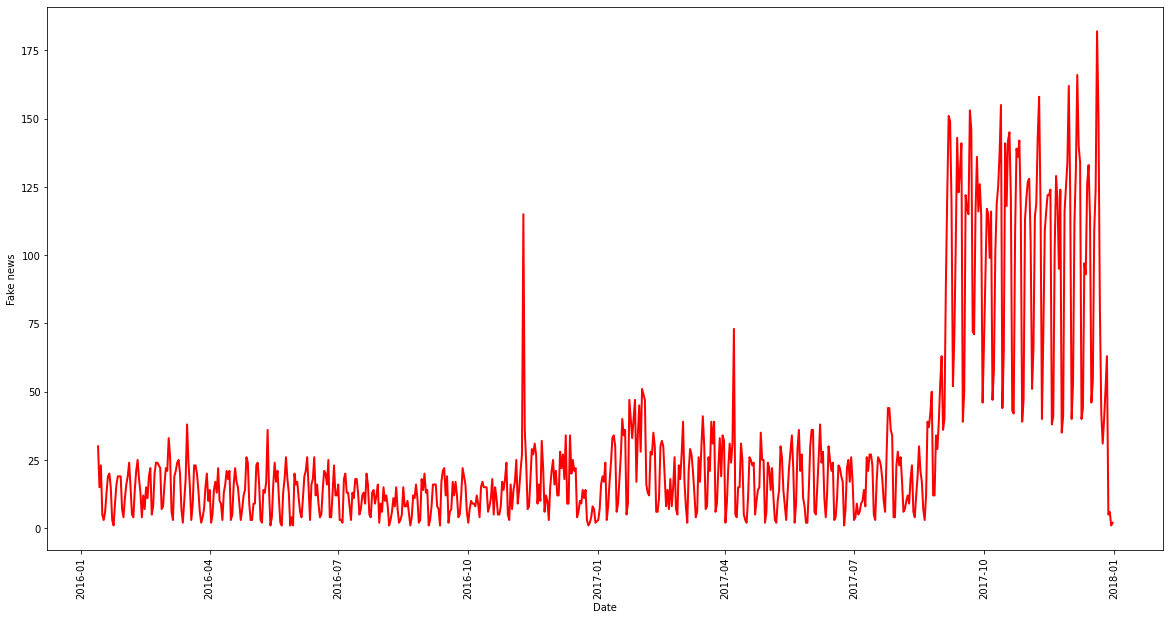

In [99]:
sample = df[['subject', 'date', 'target']]

fakes = sample.loc[(df['subject'] == 'politicsNews') | (df['subject'] == 'worldnews')]
grouped_fakes = fakes.groupby('date').target.sum()

plt.suptitle('Fake news frequency');
plt.figure(figsize=(20,10));
plt.xticks(rotation=90);
plt.ylabel('Fake news');
plt.xlabel('Date');
plt.plot(grouped_fakes.index, grouped_fakes.values, linewidth=2, color='red');


In [100]:
#TODO: Build statistics of target per month. Maybe there were pics of fake news 

#We clearly see the surge of the fake news at the end of 2017.

data_monthly = grouped_fakes.resample('M').sum()
data_monthly = data_monthly.sort_values(ascending= False).nlargest(10)
data_monthly

date
2017-10-31    3172
2017-11-30    3096
2017-09-30    3074
2017-12-31    2533
2017-01-31     750
2017-03-31     684
2017-08-31     657
2016-11-30     637
2017-02-28     591
2017-06-30     556
Name: target, dtype: int64

In [101]:
# TODO: Build statistics of subjecy per month. When people are more interested in some subjects

sample = df[['date', 'subject']]
sample_col = sample.groupby(['date'])['subject'].value_counts().unstack().fillna(0).astype(int).reindex()
month_interest  = sample_col.resample('M').sum()
month_interest

subject,Government News,Middle-east,News,US_News,left-news,politics,politicsNews,worldnews
date,,,,,,,,
2015-03-31,0,0,0,0,2,6,0,0
2015-04-30,79,0,0,0,121,126,0,0
2015-05-31,81,0,0,0,113,144,0,0
2015-06-30,66,0,0,0,77,93,0,0
2015-07-31,72,0,0,0,83,136,0,0
2015-08-31,39,0,0,0,48,133,0,0
2015-09-30,53,0,0,0,40,109,0,0
2015-10-31,77,0,0,0,59,145,0,0
2015-11-30,45,0,0,0,100,131,0,0


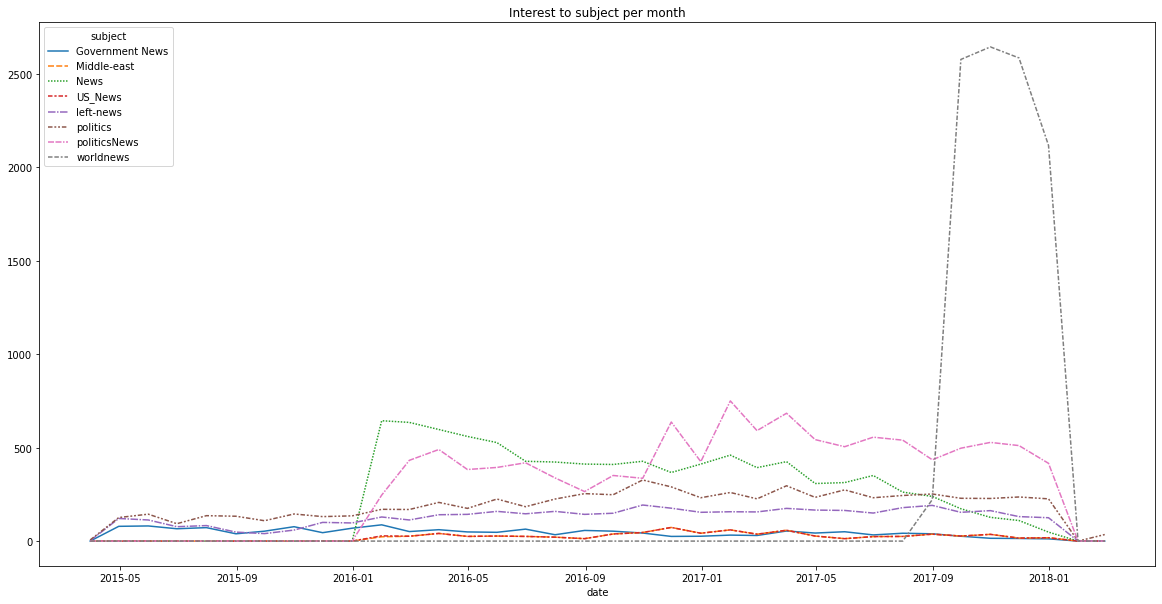

In [102]:
plt.figure(figsize=(20,10));
sns.lineplot(data=month_interest).set(title='Interest to subject per month');